#### Self-Organizing Reinforcement Learning
1. A more exciting question is how can I build a GAT module for a Snake game? It'll be the natural test-bed for SoRL -- a snake with inner-monologue. 
2. Decision Abstractive Transformer (DAT).


In [1]:
from snake import SnakeGameEngine, collect_trajectories, RandomAgent
from utils import HierTraj, data_sanity_check
from constant import PLACE_HOLDER_STATE_TOK, PLACE_HOLDER_ACTION_TOK

env = SnakeGameEngine(width=10, height=10)

# This is a make-shift data collection pipeline, the abstract tokens are complete false. 
# The proper way to collect data, per SoRL, is to 'simulate' multiple actions on the environment and store the HierTraj state directly
# in that sense, the code snippet in the middle is not useful...

# A way to use 'expert trajectory' is to take in the 'trajectories', and have the agent 'learn / explore' on what abstract tokens can be 
# used to explain the trajectory. This is very similar to the 'intuitive-physics' based 'learning by surprise' or 'active learning from obs' 
# idea. 

# For what is worth, the mid-snippet is useless (besides serving as a toy-case on which we test on SSL training of GAT)

# Collect trajectories
trajectories = collect_trajectories(env, RandomAgent(env), num_episodes=5, device="cpu")

samples = []
for trajectory in trajectories: 

    n_state = trajectory[0].size(0)
    placeholder_tokens = [PLACE_HOLDER_STATE_TOK if i % 2 == 0 else PLACE_HOLDER_ACTION_TOK for i in range(2*n_state-1)]
    sample = ([placeholder_tokens, [3, 9, 4, 2], [19, 14]], None)
    samples.append(sample)

batch_data = HierTraj.from_hierarchical_data(samples, K=3, L=3)
data_sanity_check(batch_data, trajectories)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode 0: Score=0, Reward=-11.0
Episode 1: Score=0, Reward=-10.9
Episode 2: Score=0, Reward=-10.9
Episode 3: Score=1, Reward=-0.7999999999999989
Episode 4: Score=0, Reward=-13.200000000000001
Sanity check passed: total 153 0-th level tokens (state & action)
Sanity check passed: 79 state tokens in data, 79 state tokens in trajectories
Sanity check passed: 74 action tokens in data, 74 action tokens in trajectories
Sanity check passed: 183 (action/state/abstract) tokens in data


In [2]:
from model import DAT, DATConfig

# DAT model 

config = DATConfig(
    n_layer=4,
    n_head=2,
    n_embd=32,
    K=2,
    L=3,
    vocab_size_list=[64, 32],
    device="cpu",
    _compile=True,
)

# Snake specific encoder & decoder for state & action
from snake import StateEncoder, StateDecoder, ActionEncoder, ActionDecoder

state_encoder = StateEncoder(height=10, width=10, feature_dim=config.n_embd)
state_decoder = StateDecoder(height=10, width=10, feature_dim=config.n_embd)
action_encoder = ActionEncoder(action_size=4, feature_dim=config.n_embd)
action_decoder = ActionDecoder(action_size=4, feature_dim=config.n_embd)

dat = DAT(config, state_encoder, state_decoder, action_encoder, action_decoder)

In [3]:
# compute loss
loss = dat(batch_data, trajectories)

# generate & update 
new_batch_data, new_trajectories = dat.generate(batch_data, trajectories)

# act: produce action tokens (if there already exists action-tokens un-grounded with reward, skip it)
pairs = dat.act(batch_data, trajectories) # list of (sample_idx, action_idx)


In [4]:
# Validate on 'order of generation'
from utils import test_dat_gen_order

# Sanity check-up function (order of generation)
test_dat_gen_order(dat, env, L=3, K=2, n_gen=10)


Hierarchical Trajectory K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:              [0]     
Level 1:      [0]     [0]     
L0-State: [s] [s] [s] [s]     
L0-Action:    [a] [a] [a] [a] 
Total tokens: 11, Max timestamp: 4



In [ ]:
# Create 2x2 visualization for first 4 samples
# --------------------------------------------------------------

from vis import visualize_backtrack
from utils import * 
import matplotlib.pyplot as plt

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Backtrack Visualization for First 4 Samples', fontsize=16)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Process first 4 samples
num_samples = min(4, batch_data.indices.max().item() + 1)

for i in range(num_samples):
    sample_idx = i
    
    # Get sample-level perplexity data
    per_sample_ppt, per_sample_timestamps, max_abs_ts = get_sample_level_ppl(batch_data, ppt, level=0)
    
    # Extract data for current sample
    sample_timestamps = per_sample_timestamps[sample_idx][:max_abs_ts + batch_data.K]
    sample_ppt = per_sample_ppt[sample_idx][:max_abs_ts + batch_data.K]
    
    # Select current subplot
    ax = axes_flat[i]
    
    # Plot the data
    ax.plot(sample_timestamps.cpu().numpy(), sample_ppt.cpu().numpy(), 
            'b-', linewidth=1.5, label='Perplexity')
    
    # Add threshold line
    ax.axhline(y=buffer.ppl_thres, color='r', linestyle='--', 
               linewidth=1, label=f'Threshold ({buffer.ppl_thres:.2f})')
    
    # Mark critical timestamps
    critical_mask = sample_ppt > buffer.ppl_thres
    if critical_mask.any():
        critical_ts = sample_timestamps[critical_mask]
        critical_ppt = sample_ppt[critical_mask]
        ax.scatter(critical_ts.cpu().numpy(), critical_ppt.cpu().numpy(), 
                  color='red', s=50, zorder=5, label='Critical Points')
    
    # Mark backtrack points (where cts changed for this sample)
    if sample_idx < len(cts):
        backtrack_ts = cts[sample_idx] + 1
        if backtrack_ts > 0:
            ax.axvline(x=backtrack_ts, color='green', linestyle=':', 
                      linewidth=1.5, label=f'Backtrack (t={backtrack_ts})')
    
    # Styling
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('Perplexity', fontsize=10)
    ax.set_title(f'Sample {sample_idx}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper right')
    
    # Set y-axis limits for better visualization
    ax.set_ylim([0, max(10, sample_ppt.max().item() * 1.1)])

# Hide unused subplots if less than 4 samples
for i in range(num_samples, 4):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Visualized {num_samples} samples in 2x2 grid")


In [ ]:
# Use the new helper function for cleaner multi-sample visualization
from vis import visualize_multi_sample_backtrack

# Create 2x2 grid visualization for first 4 samples
fig, axes = visualize_multi_sample_backtrack(batch_data, ppt, cts, buffer, num_samples=4)
plt.show()


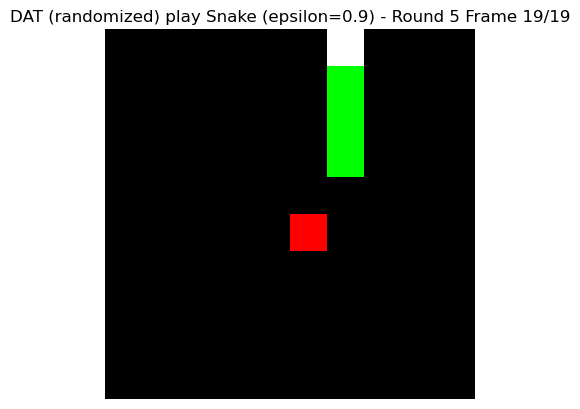

: 

In [ ]:
# Does DAT dream of playing snake game?

# from agent import HiearchicalAgent
from snake import SnakeGameEngine
from utils import draw_gif
from agent import collect_dat_game_play_frames
from agent import HiearchicalAgent

# Environment
env = SnakeGameEngine(width=10, height=10)

# DAT Agent (Snake specific agent)
# agent = HiearchicalAgent(dat, env.reset(), "cpu")

# DAT plays the snake game
# --------------------------------------------------------------------------------------------------------------------------
epsilon = 0.9
frames = collect_dat_game_play_frames(dat, env, epsilon=epsilon)
draw_gif(frames, txt=f"DAT (randomized) play Snake (epsilon={epsilon})", path="./visual/dat_snake.gif")

Training Algorithm

- Learn to Explain (GAT)
Trajectory only data --> Sample --> Train

- Learn to Explore (DAT)
No data --> Sample --> Extend & Environment Interaction --> Train

$\textbf{SoRL (GAT)}$
1. Group advantage computation 
2. Surrogate loss computation

The key for learning from experience is learning from failure

In [1]:
from dataset.nbody import NBodyDataset 

dataset = NBodyDataset(
    n_bodies=2,
    patterns=['circular'],
    T=20,
    filepath='dataset/nbody/2body_100.bin',
    num_data=100,
    K=3, 
    L=2
).build()

# dataset.sequences[0]

Generating circular with n=2, n_context=3...
Saved 100 sequences to dataset/nbody/2body_100.bin


In [1]:
from dataset.arithmetic import ArithmeticDataset


dataset = ArithmeticDataset(
    min_digit=1,
    max_digit=3,
    L=2,
    K=3,
    num_data=2000,
    filepath="dataset/multiplication/2K-123.bin"
).build()

100%|██████████| 2000/2000 [00:00<00:00, 1085763.40it/s]

Saved 2000 sequences to dataset/multiplication/2K-123.bin


In [5]:
# learn-to-explain (GAT) | one batch ver.

# (1). Initialize Data Buffer with trajectory-only data 

from model import GATConfig, GAT
from dataset.arithmetic import ArithmeticDataset

from dataclasses import asdict
from search import SORLConfig 
import wandb

gat_config = GATConfig(K=3, L=2, n_embd=128, n_head=4, n_layer=4, device="cpu", _compile=False,
                       vocab_size_list=[17, 8])
gat = GAT(gat_config)


config = SORLConfig(gat_config=gat_config, 
           n_generations=4, temperature=1.0, num_iterations=2, 
           joint_steps=10, context_length=1024, learning_rate=1e-3,
           dataset_name="100K-123", 
           dataset_path="dataset/multiplication/100K-123.bin",
           id_validate_dataset_path="dataset/multiplication/2k-123.bin",
           ood_validate_dataset_path="dataset/multiplication/2k-123.bin")

# load dataset
dataset = ArithmeticDataset.from_file(config.id_validate_dataset_path)
# id_val_dataset = ArithmeticDataset.from_file(config.id_validate_dataset_path)


# gat.load_checkpoint("experiment/nbody/SoRL-GRPO-per-token-alternate-nbody.pt")

In [6]:
from model import GAT, GATConfig 
from sanity import check_model_device
from search import get_batch


context_length = 1024 
n = 1
device = "mps"

# initialize GAT model 
gat_config = GATConfig(K=3, L=2, n_embd=128, n_head=4, n_layer=4, device=device, _compile=False,
                       vocab_size_list=[17, 8])
gat = GAT(gat_config)

# move to device
gat.to(device)
check_model_device(gat)

# get batch data
batch_data = get_batch(dataset.sequences, dataset.lengths, context_length // n, gat.L, gat.K, device=device)


All parameters matching module device on mps


In [2]:
# Record & Save an annotated dataset

# from dataset.base import BaseHierDataset
from dataset.arithmetic import ArithmeticHierDataset
from nil import annotate_abstraction
from nil import supervise_gat 

record_dataset = ArithmeticHierDataset.from_dataset(dataset)

# Greedy Abstraction Annotation (Passing knowledge to the next generation)
# ------------------------------------------------------------------------
record_dataset = annotate_abstraction(record_dataset, gat)


# Reset GAT module
# -------------------
gat = GAT(gat_config)


# Weak Supervision (GAT)
# ------------------------------------------------------------------------
weak_iterations = 100 # require tuning
context_length = 1024

supervised_gat = supervise_gat(record_dataset, gat, weak_iterations, context_length)


Iteration 1/100, loss: 4.9127, abs_loss: 2.0794, ssl_loss: 2.8332
Iteration 2/100, loss: 4.7362, abs_loss: 1.9370, ssl_loss: 2.7991
Iteration 3/100, loss: 4.4892, abs_loss: 1.7341, ssl_loss: 2.7552
Iteration 4/100, loss: 4.2146, abs_loss: 1.5094, ssl_loss: 2.7052
Iteration 5/100, loss: 3.9717, abs_loss: 1.3026, ssl_loss: 2.6691
Iteration 6/100, loss: 3.7408, abs_loss: 1.1191, ssl_loss: 2.6218
Iteration 7/100, loss: 3.5362, abs_loss: 0.9555, ssl_loss: 2.5807
Iteration 8/100, loss: 3.3784, abs_loss: 0.8085, ssl_loss: 2.5699
Iteration 9/100, loss: 3.2184, abs_loss: 0.6780, ssl_loss: 2.5404
Iteration 10/100, loss: 3.0805, abs_loss: 0.5644, ssl_loss: 2.5161
Iteration 11/100, loss: 2.9727, abs_loss: 0.4672, ssl_loss: 2.5055
Iteration 12/100, loss: 2.8609, abs_loss: 0.3852, ssl_loss: 2.4758
Iteration 13/100, loss: 2.7815, abs_loss: 0.3173, ssl_loss: 2.4642
Iteration 14/100, loss: 2.7241, abs_loss: 0.2617, ssl_loss: 2.4625
Iteration 15/100, loss: 2.6535, abs_loss: 0.2164, ssl_loss: 2.4371
Iter

Keep it beautifully simple

In [ ]:
# Benchmark RL & SSL combination strategies 
# (I). Pick the best & learn it 
# -------------------------------------------------------------
import copy 
import wandb
import torch
from search import compute_ssl_loss, get_batch, eval_search_improvement
from search import compute_abs_ssl_loss
from search import sorl_search_v2
from search import compute_curriculum_t_increment, eval_ppl_with_search, curriculum_iter

n = 3 
temperature = 1.0
num_iterations = 200
context_length = 1024
global_step = 0 

optimizer = torch.optim.Adam(gat.parameters(), lr=1e-3)
gat.train() 

# curriculum
t_search = 0
t_delta, t_max = compute_curriculum_t_increment(num_iterations=num_iterations, context_length=context_length, K=gat.K, max_ts=max(dataset.lengths))

while global_step < num_iterations: 

    batch_data = get_batch(dataset.sequences, dataset.lengths, context_length // n, gat.L, gat.K)

    with torch.no_grad(): 
        repeat_batch, switch_ratio, rollout_advantages = sorl_search_v2(gat, batch_data, n, temperature, t_search) # pinned greedy sample ver.

    ppt = gat(repeat_batch)

    ssl_loss = compute_ssl_loss(repeat_batch, ppt)
    abs_loss = compute_abs_ssl_loss(repeat_batch, ppt, level=1)

    loss = abs_loss + ssl_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"Iteration {global_step+1}/{num_iterations}, loss: {loss.item():.4f}, abs_loss: {abs_loss.item():.4f}, ssl_loss: {ssl_loss.item():.4f}")

    global_step += 1
    t_search = min(t_search + t_delta, t_max)
    del loss, abs_loss, ssl_loss
    
    # train data ppl improvement
    improve_ppl_train = eval_search_improvement(gat, batch_data, t_search=t_search)
    print(f"\nImprove ppl percentage (train): {improve_ppl_train:.4f}")
    print(f"per-sample abstraction switch ratio: {switch_ratio:.4f} | t_search: {t_search} | (How often greedy sample is rejected by other abstraction)")
    # s = observe_abstraction(batch_data, gat, t_search=t_search, temperature=0.0)
    # print(s)

    # if global_step % 10 == 0: 
    if False: 
        val_data = get_batch(id_val_dataset.sequences, id_val_dataset.lengths, context_length, gat.L, gat.K)
        
        with torch.no_grad(): 
            improve_ppl_val = eval_search_improvement(gat, val_data, t_search=t_search)
            print(f"Improve ppl percentage (val): {improve_ppl_val:.4f}\n")
        
            if t_search == t_max:
                traj_ppl_val = eval_ppl_with_search(val_data, gat, dataset.answer_token_id, n=6, temperature=1.0)
                print(f"Traj ppl (val): {traj_ppl_val.mean().item():.4f}\n")

            if not config.t_curriculum: 
                traj_ppl_val = eval_generate_ppl(gat, val_data, n=1, temperature=0.0, t_search=t_search).mean()
                print(f"Traj ppl (val): {traj_ppl_val.item():.4f}\n")

 - number of switched abstraction: 0, ratio: 0.0000
 - average advantage over greedy choice: 0.0000
Threshold decreased to 0.0
Iteration 1/200Joint iter 1/1, loss: 2.8332, abs_loss: 0.0000, ssl_loss: 2.8332

Improve ppl percentage (train): 0.0000
per-sample abstraction switch ratio: 0.0000 | t_search: 1 | (How often greedy sample is rejected by other abstraction)
 - number of switched abstraction: 30, ratio: 1.0000
 - average advantage over greedy choice: 0.0015
Threshold increased to 0.0006239890935830772
Iteration 2/200Joint iter 1/1, loss: 4.8680, abs_loss: 2.0794, ssl_loss: 2.7886

Improve ppl percentage (train): 0.0528
per-sample abstraction switch ratio: 1.0000 | t_search: 2 | (How often greedy sample is rejected by other abstraction)
 - number of switched abstraction: 4, ratio: 0.1600
 - average advantage over greedy choice: 0.0017
Threshold decreased to 0.0004746007907669991
Iteration 3/200Joint iter 1/1, loss: 4.7327, abs_loss: 1.9868, ssl_loss: 2.7459

Improve ppl percentage 